In [1]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
from PIL import Image

In [2]:
def pano_plot(x, y, paths, patch_size=(3, 3), ax0=None):
    """
    Graphs y vs x with images on plot instead of points.
    Generates 'panoramic' image plots which are useful for visualizing how images 
    separate in feature space for clustering and classification challenges.
    
    Parameters
    ---------------
    x, y: ndarray
        n-element arrays of x and y coordinates for plot
        
    paths: list of strings or path objects
        n-element list of paths to images to be displaied at each point
        
    patch_size: tuple(int, int)
        size of the image patches displayed at each point
        
    ax0: None or matplotlib axis object
        if None, a new figure and axis will be created and the visualization will be displayed.
        if an axis is supplied, the panoramic visualization will be plotted on the axis in place.
        
    Returns
    ----------
    None
    
    """
    if ax0 is None:
        fig, ax = plt.subplots(figsize=(7, 7), dpi=150)
    else:
        ax = ax0
    px, py = patch_size
    ax.scatter(x, y, color=(0, 0, 0, 0))
    for xi, yi, pi in zip(x, y, paths):
        im = skimage.io.imread(pi)
        ax.imshow(im, extent=(xi - px, xi + px, yi - py, yi + py), cmap='gray')

    if ax0 is None:
        plt.show()

#### Load data

In [3]:
#fc1_path = Path('/home/richard/data/Schiefer/features/VGG16_fc1_feature_std.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/VGG16_fc1_feature_std_224.pickle')
#fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std.pickle')
fc1_path = Path('/home/richard/data/Schiefer/features/ResNet152_feature_std_224.pickle')
assert fc1_path.is_file()

# load the data and label encoder into memory
with open(fc1_path, 'rb') as f:
    data = pickle.load(f)

In [4]:
files = data['filename']
fc1 = data['features']

In [5]:
print(type(fc1[0]))

<class 'numpy.ndarray'>


#### Dimension reduction
#### PCA

- PCA reduce dimensionality and filter out noise in the data
- How many dimensions to keep?
- No clear answer, but keep components that contain **signal** (significant variance) and **get rid of ones** that are mostly noise
  - A: rule of thumb for high dimensional data is to select 50 components
  - inspect how much variance each component preserves before selecting 50
  - B: or directly aim for an automated process to determine the amount of components

#### A

variance preserved by 50 components: 0.892


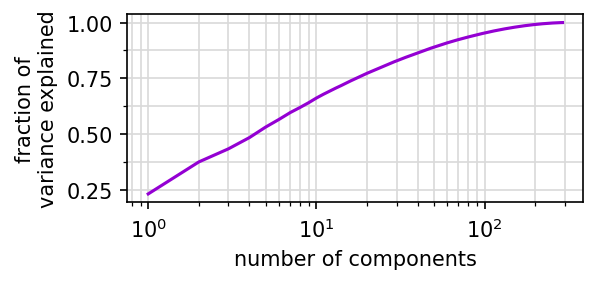

In [6]:
pca_n = PCA(svd_solver='full')
x_pca_ = pca_n.fit_transform(fc1) # apply reduction on x

var_ = pca_n.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(figsize=(4,2),dpi=150,)
ax.grid('on', which='both', color=np.ones(3)*0.85)
ax.plot(range(1,len(var_)+1), var_, color='darkviolet')
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('fraction of\nvariance explained')

yt=np.linspace(1/4, 1, 4)
ytm = [np.mean([yt[i], yt[i+1]]) for i in range(len(yt)-1)]
ax.set_yticks(ytm, minor=True)

fig.tight_layout()
#fig.savefig(Path('..','Figures','PCA_Var.png'), bbox_inches='tight')
print('variance preserved by 50 components: {:.3f}'.format(var_[50]))

#### B

In [7]:
# select pca data
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(fc1) # scale data to the range between 0 and 1
pca = PCA(n_components = 0.95) # wand explained variace between 95-99%
pca.fit(data_rescaled)
reduced = pca.fit_transform(data_rescaled)
print(reduced.shape)

(291, 204)


#### Determine the optimal number of clusters k

#### A: Elbow Method

1 : 5.837302537523057
2 : 5.582836817311996
3 : 5.434887254088148
4 : 5.371327442323812
5 : 5.335285134619449
6 : 5.257360124887152
7 : 5.257266039088963
8 : 5.213747057514917
9 : 5.176857591361305


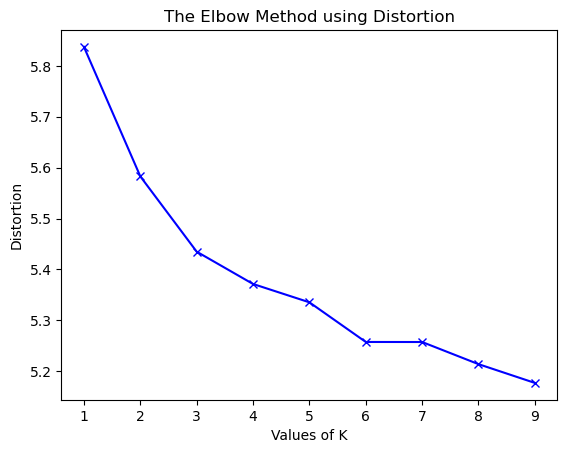

In [8]:
# determine optimal number of k -> we know from Schiefer labels that this image contains 4 classes
# with elbow method
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_init=10,n_clusters=k).fit(reduced)
    kmeanModel.fit(reduced)
  
    distortions.append(sum(np.min(cdist(reduced, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / reduced.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(reduced, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / reduced.shape[0]
    mapping2[k] = kmeanModel.inertia_

for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

#### B: Scaled Insertia Method

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    9.0s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:   12.5s remaining:   19.6s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:   18.4s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:   25.0s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   30.0s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   32.7s remaining:    6.5s


best k is 4


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   36.7s finished


([<matplotlib.axis.XTick at 0x7fa838cb51f0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

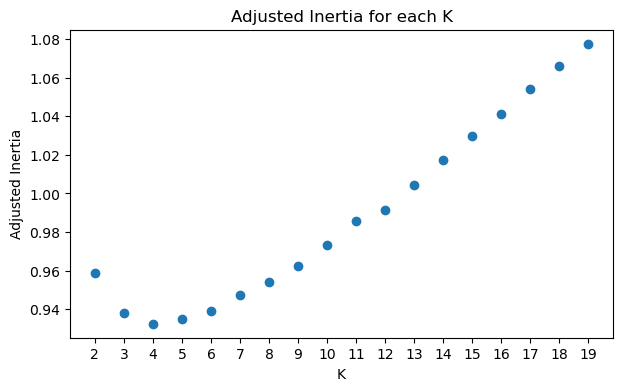

In [9]:
# scaled inertia approach to determine optimal k
def kMeansRes(scaled_data, k, alpha_k=0.02):
    '''
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k: int
        current k for applying KMeans
    alpha_k: float
        manually tuned factor that gives penalty to the number of clusters
    Returns 
    -------
    scaled_inertia: float
        scaled inertia value for current k           
    '''
    
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    # fit k-means
    kmeans = KMeans(n_init=500,n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def chooseBestKforKMeansParallel(scaled_data, k_range):
    '''
    Parameters 
    ----------
    scaled_data: matrix 
        scaled data. rows are samples and columns are features for clustering
    k_range: list of integers
        k range for applying KMeans
    Returns 
    -------
    best_k: int
        chosen value of k out of the given k range.
        chosen k is k with the minimum scaled inertia value.
    results: pandas DataFrame
        adjusted inertia value for each k in k_range
    '''
    
    ans = Parallel(n_jobs=-1,verbose=10)(delayed(kMeansRes)(scaled_data, k) for k in k_range)
    ans = list(zip(k_range,ans))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

def chooseBestKforKMeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kMeansRes(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results

# choose k range
k_range=range(2,20)
# compute adjusted intertia
best_k, results = chooseBestKforKMeansParallel(reduced, k_range)
print("best k is",best_k)

# plot the results
plt.figure(figsize=(7,4))
plt.plot(results,'o')
plt.title('Adjusted Inertia for each K')
plt.xlabel('K')
plt.ylabel('Adjusted Inertia')
plt.xticks(range(2,20,1))

#### Apply KMeans

In [10]:
# initialize model
model = KMeans(n_clusters=4, random_state=42)

#fit data into the model
model.fit(reduced)

# extract labels
labels = model.labels_

print(labels)
print(type(labels))

[2 0 3 2 3 3 3 2 3 3 1 0 2 0 1 3 1 1 1 3 1 3 1 3 3 3 3 2 2 2 2 2 1 2 0 2 3
 3 3 2 0 3 3 3 2 2 1 1 3 1 0 3 3 3 2 2 2 3 3 1 2 3 1 3 2 0 3 3 3 2 0 3 0 3
 1 3 3 3 2 3 3 3 3 3 3 2 3 2 2 2 2 2 1 2 0 1 2 3 2 1 1 2 3 2 1 0 3 2 3 3 2
 2 3 3 1 2 2 3 2 1 3 3 3 2 3 3 2 3 2 3 3 3 2 3 2 3 3 3 2 3 2 3 3 2 3 1 2 0
 0 3 2 1 2 3 3 0 2 3 2 3 3 3 3 3 3 2 2 1 3 3 3 3 2 3 3 0 2 3 2 3 0 0 3 2 2
 3 3 3 0 2 2 3 3 3 3 3 3 2 2 2 1 1 1 2 2 1 0 2 1 3 2 2 3 2 1 1 2 1 3 0 1 2
 3 2 2 1 2 2 2 0 2 2 3 2 2 2 2 2 1 0 3 1 3 1 2 3 2 3 1 2 2 1 2 3 2 3 2 0 2
 3 3 2 1 3 1 3 3 2 3 0 2 2 2 3 2 2 2 2 3 0 3 3 0 2 3 0 3 2 2 2 1]
<class 'numpy.ndarray'>


/home/richard/mambaforge/envs/detectree2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
# make df, optional
df = pd.DataFrame(columns=['filename','label'])
df['filename'] = files
df['label'] = labels
df.head()

#df.to_csv('/home/richard/data/Schiefer/clustering_results.csv')
# TODO: Include values from clustering alg

,filename,label
0,/home/richard/data/Schiefer/preprocessed_224/C...,2
1,/home/richard/data/Schiefer/preprocessed_224/C...,0
2,/home/richard/data/Schiefer/preprocessed_224/C...,3
3,/home/richard/data/Schiefer/preprocessed_224/C...,2
4,/home/richard/data/Schiefer/preprocessed_224/C...,3


#### Visualization of results

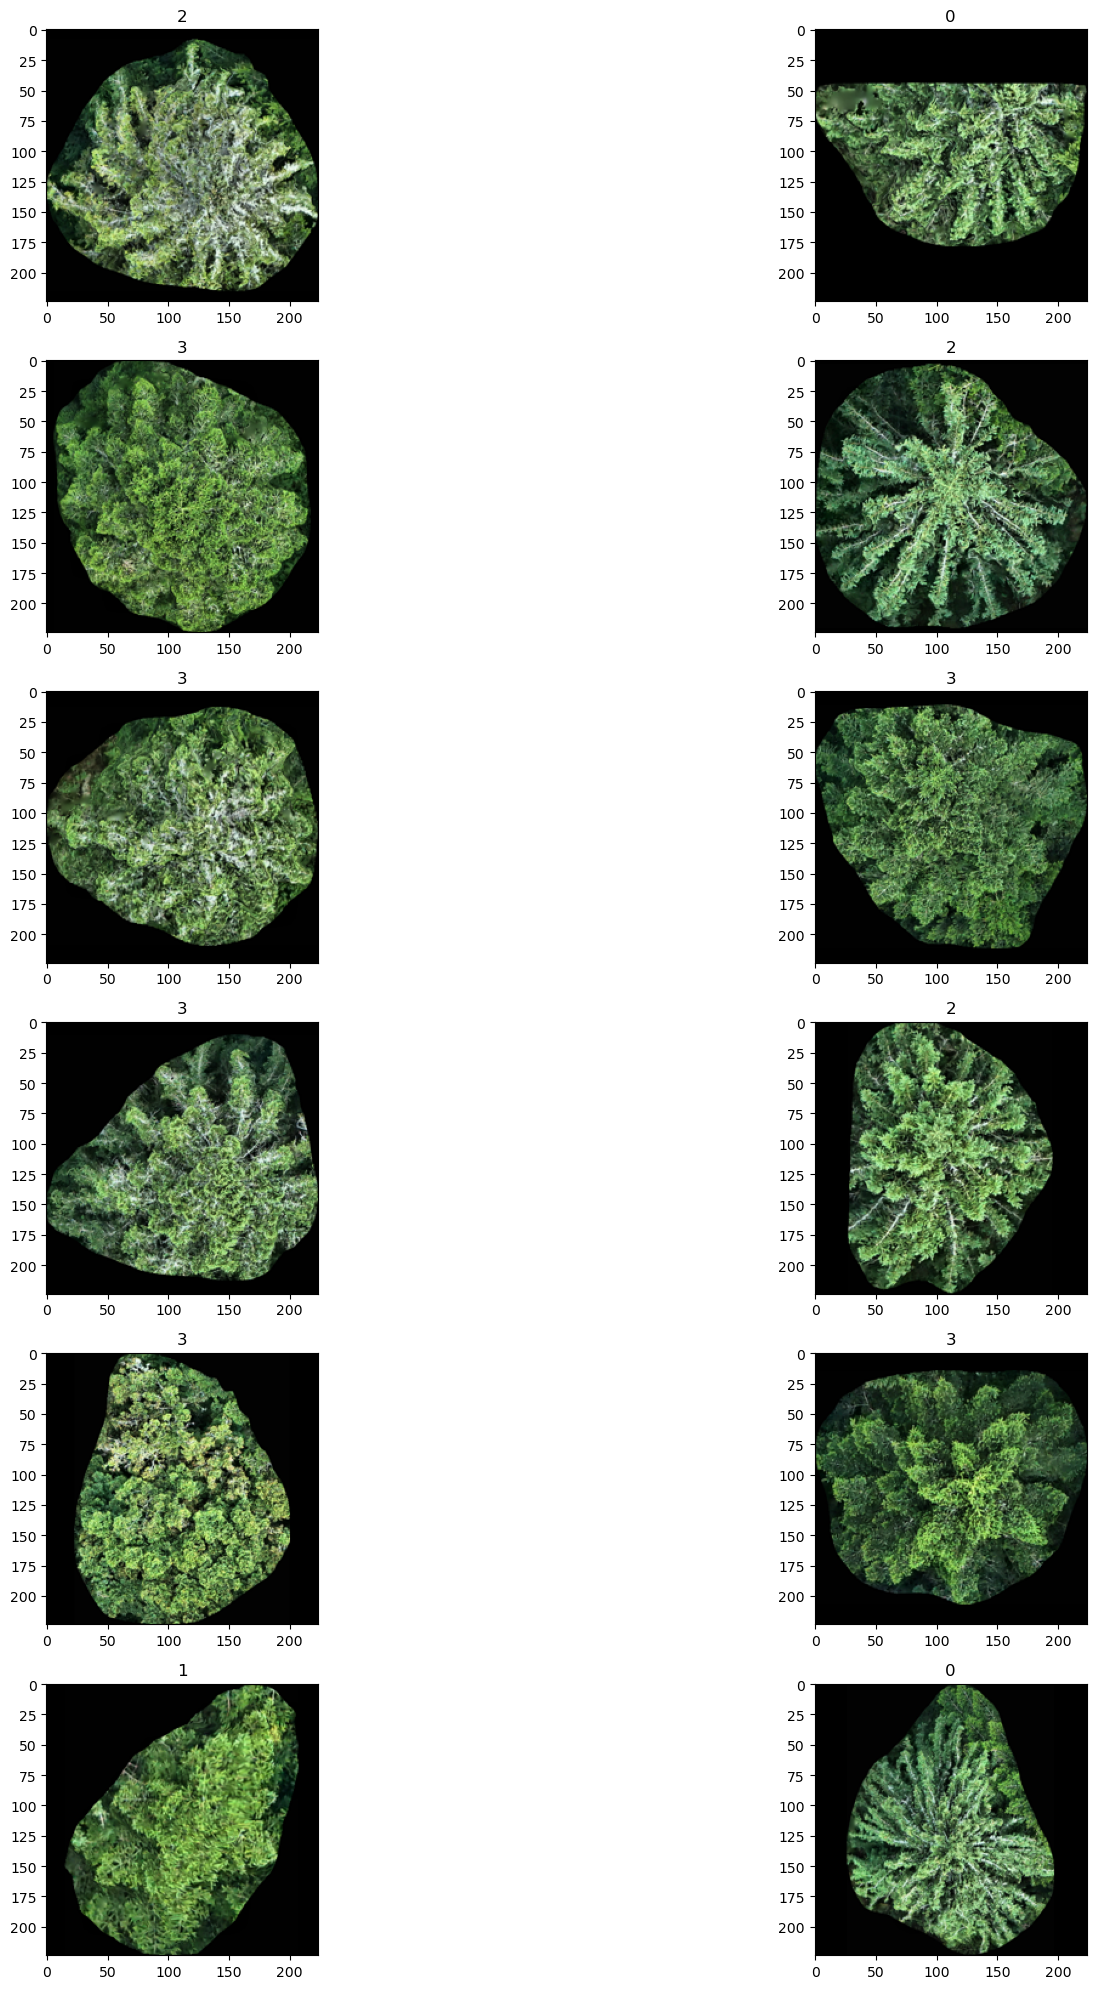

In [12]:
n_row = 6
n_col = 2
_, axs = plt.subplots(n_row, n_col, figsize=(20, 20))
axs = axs.flatten()
imgs = df['filename']
for img_path, ax in zip(imgs[0:n_row*n_col], axs):
    img = Image.open(img_path)
    label_value = df.loc[df.filename == img_path, 'label'].values[0]
    ax.set_title(label_value)
    ax.imshow(img)
plt.tight_layout()
plt.show()

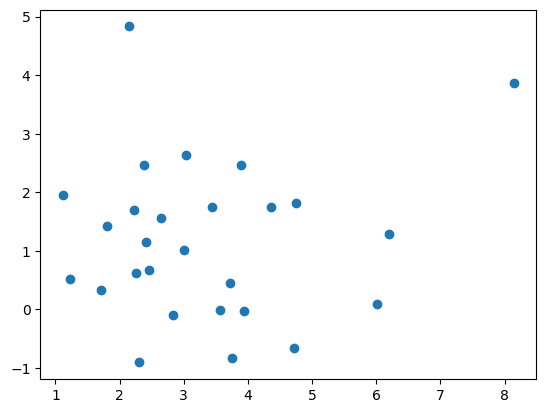

In [13]:
# plot label 0 k means cluster
filtered_labels0 = reduced[labels == 0]
plt.scatter(filtered_labels0[:,0] , filtered_labels0[:,1])
plt.show()

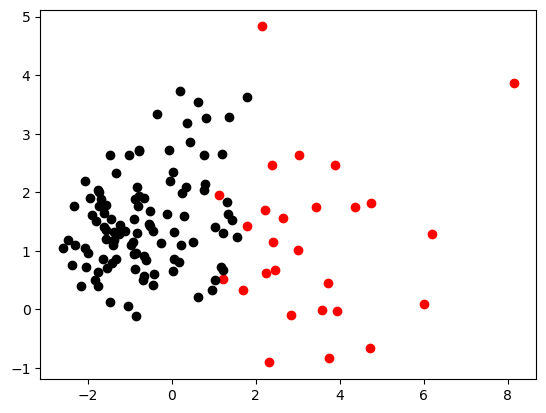

In [14]:
#filter rows of original data
filtered_label2 = reduced[labels == 0]
 
filtered_label8 = reduced[labels == 2]
 
#Plotting the results
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'red')
plt.scatter(filtered_label8[:,0] , filtered_label8[:,1] , color = 'black')
plt.show()

[0 1 2 3]


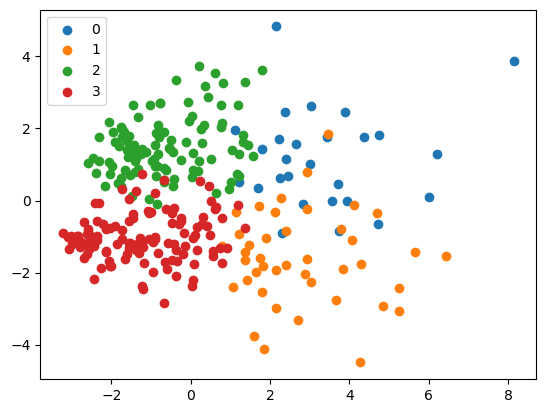

In [15]:
# plot all labels
u_labels = np.unique(labels)
print(u_labels)

for i in u_labels:
    plt.scatter(reduced[labels == i , 0] , reduced[labels == i , 1] , label = i)
plt.legend()
plt.show()


#### T-SNE Visulization

T-SNE maps components in high-dimensional space to lower dimensions. Used to project data to 2d for visulization. Technique preserve pairwise distances for points.

In [16]:
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(fc1) # scale data to the range between 0 and 1

# tsne
pca_nw = PCA(n_components=0.95, svd_solver='full', whiten=False)
x_nw = pca_nw.fit_transform(data_rescaled)

tsne = TSNE(n_components=2, random_state=12214) # reducing dimension to two
x_nw_tsne = tsne.fit_transform(x_nw)

# scale coordinates to fit 0:1
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = x_nw_tsne[:, 0]
ty = x_nw_tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

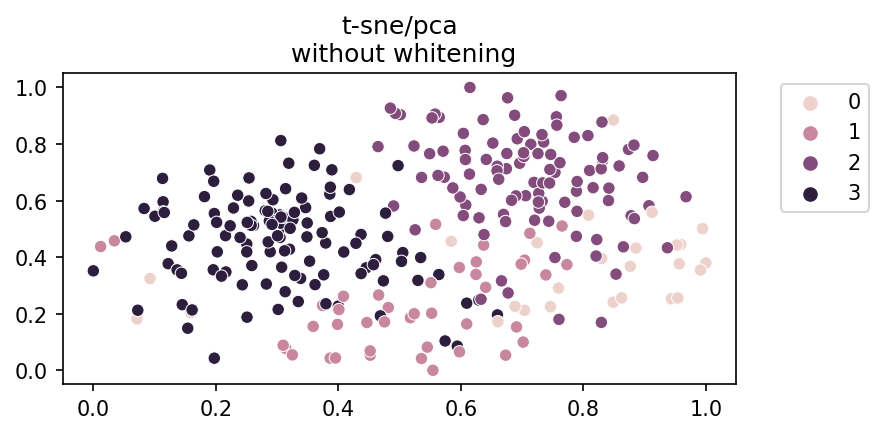

In [17]:
df = pd.DataFrame({'files': files,
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1, figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x=tx, y=ty, hue='labels')
ax.legend(bbox_to_anchor=(1.05,1))
ax.set_title('t-sne/pca\n without whitening')
fig.tight_layout()
plt.show()